In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
model_type = "profile"

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [ ]:
# SPI1
condition_name = "SPI1"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/SPI1/SPI1_training_paths.json" % model_type)
num_tasks = 4
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "SPI1_keep1/11/model_ckpt_epoch_2.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior_keep1/14/model_ckpt_epoch_3.pt")
peak_retention = "top 1%"

In [ ]:
# GATA2
condition_name = "GATA2"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/GATA2/GATA2_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "GATA2_keep1/6/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior_keep1/14/model_ckpt_epoch_3.pt")
peak_retention = "top 1%"

In [ ]:
# K562
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/%s/config/K562/K562_training_paths.json" % model_type)
condition_name = "K562"
num_tasks = 1
num_strands = 1
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "K562/18/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior/9/model_ckpt_epoch_8.pt")
peak_retention = "all"

In [4]:
# BPNet
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
condition_name = "BPNet"
num_tasks = 3
num_strands = 2
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "BPNet_keep1/12/model_ckpt_epoch_19.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior_keep1/21/model_ckpt_epoch_19.pt")
peak_retention = "top 1%"

### Import models

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [7]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [8]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model. We'll also need to be able to determine the location of the summit for each coordinate. This is a little more tricky for binary models.

In [9]:
# Extract the set of peak BEDs; this is hacky way to do it
profile_files_spec_path = files_spec_path.replace("binary", "profile")
with open(profile_files_spec_path, "r") as f:
    spec = json.load(f)
    peak_bed_paths = spec["peak_beds"]

In [10]:
# Import the peak BEDs; in the meantime, add a column for the actual
# summit position, not just the offset with respect to the peak
peak_beds = []
for peak_bed_path in peak_bed_paths:
    table = pd.read_csv(
        peak_bed_path, sep="\t", header=None,  # Infer compression
        names=[
            "chrom", "peak_start", "peak_end", "name", "score",
            "strand", "signal", "pval", "qval", "summit_offset"
        ]
    )
    table = table[table["chrom"].isin(chrom_set)]
    table["summit_pos"] = table["peak_start"] + table["summit_offset"]
    peak_beds.append(table)

In [11]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_profile_coords(
        files_spec_path, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_binary_bins(
        files_spec_path, chrom_set=chrom_set
    )

### Compute importances

In [12]:
# Pick a sample of 1000 random coordinates/bins
num_samples = 1000
sample = pos_examples[np.random.choice(len(pos_examples), size=num_samples, replace=False)]

In [13]:
# For profile models, add a random jitter to avoid center-bias
if model_type == "profile":
    jitters = np.random.randint(-128, 128 + 1, size=len(sample))
    sample[:, 1] = sample[:, 1] + jitters
    sample[:, 2] = sample[:, 2] + jitters

In [14]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [15]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [16]:
# Compute the importance scores and 1-hot seqs
imp_type = ("SHAP scores", "input gradients")[0]
imp_func = compute_shap_scores if imp_type == "SHAP scores" else compute_gradients
noprior_scores, _ = imp_func(noprior_model, sample)
prior_scores, one_hot_seqs = imp_func(prior_model, sample)

['chr1' 12354368 12354712]
Without priors:


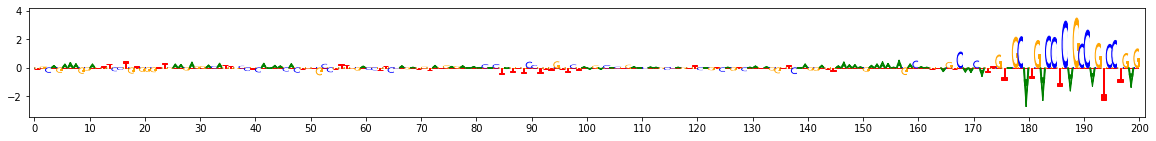

With priors:


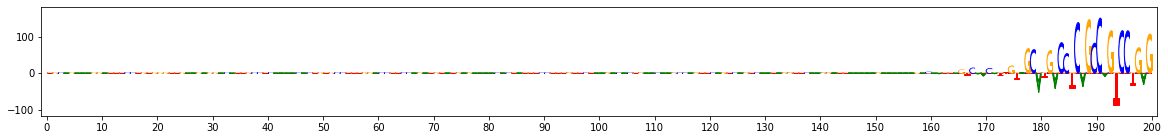

['chr1' 36884088 36884432]
Without priors:


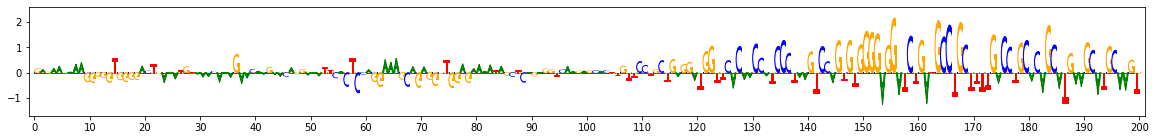

With priors:


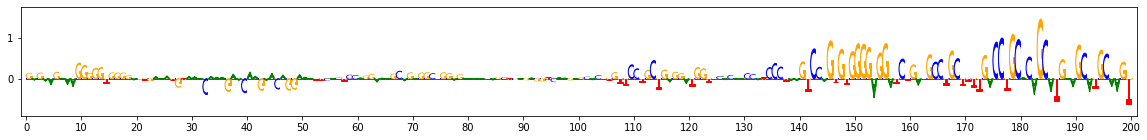

['chr1' 11395912 11396212]
Without priors:


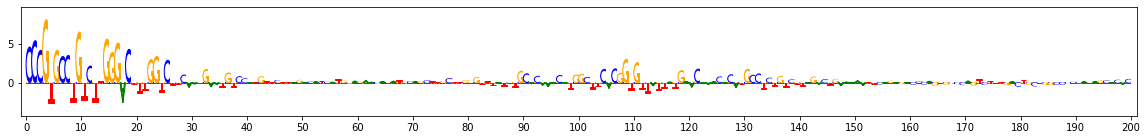

With priors:


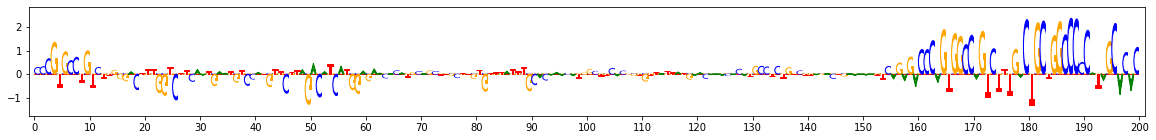

In [17]:
# Plot out a few examples
center_slice = slice(400, 600)
for i in np.random.choice(num_samples, size=3, replace=False):
    print(sample[i])
    print("=========================")
    print("Without priors:")
    viz_sequence.plot_weights(noprior_scores[i, center_slice] * one_hot_seqs[i, center_slice], subticks_frequency=10)
    print("With priors:")
    viz_sequence.plot_weights(prior_scores[i, center_slice] * one_hot_seqs[i, center_slice], subticks_frequency=10)

### Correlate importance to distance from summit

In [18]:
def get_summit_location(chrom, start, end):
    """
    Gets the locations of all summits that overlap this interval,
    relative to the given start and end.
    """
    summits = []
    for peak_bed in peak_beds:
        rows = peak_bed[
            (peak_bed["chrom"] == chrom) & \
            (peak_bed["summit_pos"] >= start) & \
            (peak_bed["summit_pos"] < end)
        ]
        if not len(rows):
            continue
        summits.extend(list(rows["summit_pos"] - start))
    return summits

In [19]:
def compute_summits(sample):
    """
    Given a sample of N coordinates or bins, extracts the set of summit
    as offsets to the sample coordinates. Returns an N x 3 object array
    of coordinates (may just be `sample`), and a list of N sublists, with
    each sublist being the set of overlapping summit offsets.
    """
    summits = []
    if model_type == "profile":
        for coord in tqdm.notebook.tqdm(sample):
            # Pad to profile length
            start = ((coord[1] + coord[2]) // 2) - (input_length // 2)
            end = start + input_length
            summits.append(get_summit_location(coord[0], start, end))
        return sample, summits
    else:
        coords = np.empty((len(sample), 3), dtype=object)
        for i in tqdm.notebook.trange(len(sample)):
            coord = input_func(np.array([sample[i]]))[2][0]
            coords[i] = coord
            summits.append(get_summit_location(coord[0], coord[1], coord[2]))
        return coords, summits

In [20]:
def compute_windowed_distance_corr(scores, one_hot_seqs, summit_offsets, window_size=1):
    """
    Windowing by `window_size`, computes the total importance magnitude for the
    actual importance in each window, and correlates that to the distance from
    the summit. If there are multiple summits, then the closest one is used.
    Returns a NumPy array of correlation values, one for each sequence (where
    each correlation is done over the windows of the sequence).
    """
    num_samples = len(scores)
    corr_vals = np.empty(num_samples)
    for i in tqdm.notebook.trange(num_samples):
        score_track = np.sum(np.abs(scores[i] * one_hot_seqs[i]), axis=1)  # Actual importance
        offsets = summit_offsets[i]
        if not offsets:
            print("Warning: found a sequence with no captured summit")
            corr_vals[i] = 0
            continue
        num_windows = len(score_track) - window_size + 1
        
        # Compute distances to summits
        distances = np.empty((len(offsets), num_windows))
        window_locs = np.arange(num_windows) + ((len(score_track) - num_windows) / 2)
        for j, offset in enumerate(offsets):
            distances[j] = np.abs(window_locs - offset)
        closest_distances = np.amin(distances, axis=0)
        
        # Compute sum of importance in each window
        importances = np.empty(num_windows)
        for j in range(num_windows):
            importances[j] = np.sum(score_track[j : j + window_size])
        
        corr_vals[i] = scipy.stats.spearmanr(importances, closest_distances)[0]
    return corr_vals

In [21]:
coords, summit_offsets = compute_summits(sample)
noprior_corrs = compute_windowed_distance_corr(noprior_scores, one_hot_seqs, summit_offsets, window_size=10)
prior_corrs = compute_windowed_distance_corr(prior_scores, one_hot_seqs, summit_offsets, window_size=10)

Average correlation without priors: -0.358033
Average correlation with priors: -0.388828
One-sided paired t-test p: 0.000256


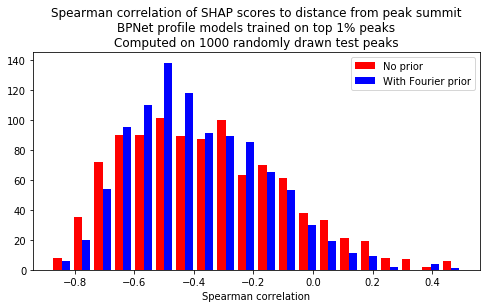

In [22]:
bin_num = 20
plt.figure(figsize=(8, 4))
plt.hist(
    [noprior_corrs, prior_corrs],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"]
)
plt.title(
    ("Spearman correlation of %s to distance from peak summit" % imp_type) +
    ("\n%s %s models trained on %s peaks" % (condition_name, model_type, peak_retention)) +
    ("\nComputed on %d randomly drawn test peaks" % len(sample))
)
plt.legend()
plt.xlabel("Spearman correlation")

print("Average correlation without priors: %f" % np.mean(noprior_corrs))
print("Average correlation with priors: %f" % np.mean(prior_corrs))
t, p = scipy.stats.ttest_rel(noprior_corrs, prior_corrs)
print("One-sided paired t-test p: %f" % (p / 2))

Text(0.5, 0, 'Correlation difference: no prior - with prior')

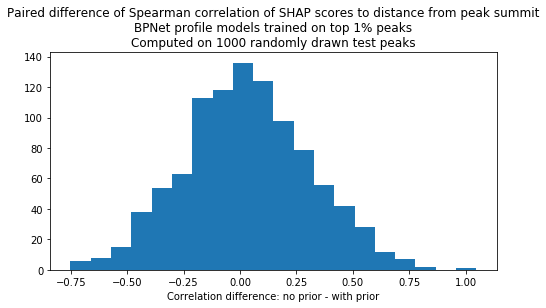

In [23]:
diff_corrs = noprior_corrs - prior_corrs
plt.figure(figsize=(8, 4))
plt.hist(diff_corrs, bins=20)
plt.title(
    ("Paired difference of Spearman correlation of %s to distance from peak summit" % imp_type) +
    ("\n%s %s models trained on %s peaks" % (condition_name, model_type, peak_retention)) +
    ("\nComputed on %d randomly drawn test peaks" % len(sample))
)
plt.xlabel("Correlation difference: no prior - with prior")

### Ranked enrichment of peak overlap and summit closeness with importance

In [24]:
def normed_rank_enrichment(ordered_mask):
    """
    From a binary mask array (in order from best to worst thresholds), computes
    the rank enrichment at each threshold. Specifically, this computes a
    normalized CDF of how many 1s are seen in the first k instances.
    """
    cdf = np.cumsum(ordered_mask)
    # To normalize, divide by the expectation if there all 1s were spread
    # out evenly across the instances
    expectation = np.sum(ordered_mask) / len(ordered_mask) * np.arange(1, len(cdf) + 1)
    return cdf / expectation

In [25]:
def get_peak_overlap(chrom, start, end):
    """
    Given a coordinate, returns a boolean mask for that coordinate
    for which bases lie within a peak.
    """
    mask = np.zeros(end - start, dtype=bool)
    for peak_bed in peak_beds:
        rows = peak_bed[
            (peak_bed["chrom"] == chrom) & \
            (peak_bed["peak_start"] <= end) & \
            (start <= peak_bed["peak_end"])
        ]
        intervals = rows[["peak_start", "peak_end"]].values - start
        for interval in intervals:
            mask[interval[0]:interval[1]] = True
    return mask

In [26]:
def compute_peak_overlap(sample):
    """
    Given a sample of N coordinates or bins, extracts a boolean mask
    denoting which locations in each sample overlap a peak.
    Returns an N x 3 object array of coordinates (may just be `sample`), and
    an N x I boolean array, where each subarray is a boolean mask for which
    bases in that coordinate lie within a peak.
    """
    masks = []
    if model_type == "profile":
        for coord in tqdm.notebook.tqdm(sample):
            # Pad to profile length
            start = ((coord[1] + coord[2]) // 2) - (input_length // 2)
            end = start + input_length
            masks.append(get_peak_overlap(coord[0], start, end))
        return sample, np.stack(masks, axis=0)
    else:
        coords = np.empty((len(sample), 3), dtype=object)
        for i in tqdm.notebook.trange(len(sample)):
            coord = input_func(np.array([sample[i]]))[2][0]
            coords[i] = coord
            masks.append(get_peak_overlap(coord[0], coord[1], coord[2]))
        return coords, np.stack(masks, axis=0)

In [27]:
def compute_peak_mask(scores, one_hot_seqs, seq_peak_masks, window_size=1):
    """
    Windowing by `window_size`, computes the total importance magnitude for the
    actual importance in each window, and identifies which windows overlap a peak.
    Returns a boolean NumPy array denoting which windows overlap a peak, sorted in
    descending order of window importance. This requires a mask of whether or not
    each base in each input sequence overlaps a peak, computed by `compute_peak_overlap`.
    """
    num_samples = len(scores)
    all_window_imps, all_peak_masks = [], []
    all_window_inds = []
    for i in tqdm.notebook.trange(num_samples):
        score_track = np.sum(np.abs(scores[i] * one_hot_seqs[i]), axis=1)  # Actual importance
        offsets = summit_offsets[i]
        if not offsets:
            print("Warning: found a sequence with no captured summit")
            continue
        num_windows = len(score_track) - window_size + 1
        
        # Compute windowed peak mask
        window_locs = np.arange(num_windows) + ((len(score_track) - num_windows) / 2)
        windowed_peak_mask = seq_peak_masks[i][window_locs.astype(int)]
        
        # Compute sum of importance in each window
        importances = np.empty(num_windows)
        for j in range(num_windows):
            importances[j] = np.sum(score_track[j : j + window_size])
            all_window_inds.append([i, j])
        
        all_window_imps.append(importances)
        all_peak_masks.append(windowed_peak_mask)
    
    window_imps, all_peak_masks = np.concatenate(all_window_imps), np.concatenate(all_peak_masks)
    all_window_inds = np.stack(all_window_inds)
    return all_peak_masks[np.flip(np.argsort(window_imps))], all_window_inds[np.flip(np.argsort(window_imps))]

In [28]:
sample_coords, peak_masks = compute_peak_overlap(sample)
# noprior_peak_mask = compute_peak_mask(noprior_scores, one_hot_seqs, peak_masks, window_size=10)
# prior_peak_mask = compute_peak_mask(prior_scores, one_hot_seqs, peak_masks, window_size=10)
noprior_peak_mask, noprior_windows = compute_peak_mask(noprior_scores, one_hot_seqs, peak_masks, window_size=10)
prior_peak_mask, prior_windows = compute_peak_mask(prior_scores, one_hot_seqs, peak_masks, window_size=10)

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


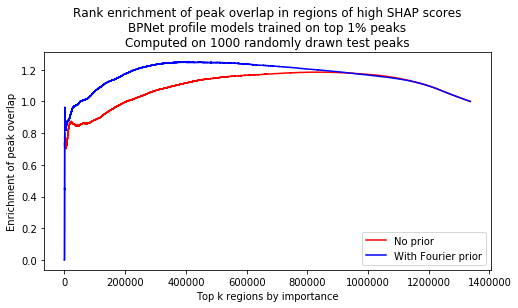

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(normed_rank_enrichment(noprior_peak_mask), label="No prior", color="red")
plt.plot(normed_rank_enrichment(prior_peak_mask), label="With Fourier prior", color="blue")
plt.title(
    ("Rank enrichment of peak overlap in regions of high %s" % imp_type) +
    ("\n%s %s models trained on %s peaks" % (condition_name, model_type, peak_retention)) +
    ("\nComputed on %d randomly drawn test peaks" % len(sample))
)
plt.xlabel("Top k regions by importance")
plt.ylabel("Enrichment of peak overlap")
plt.legend()

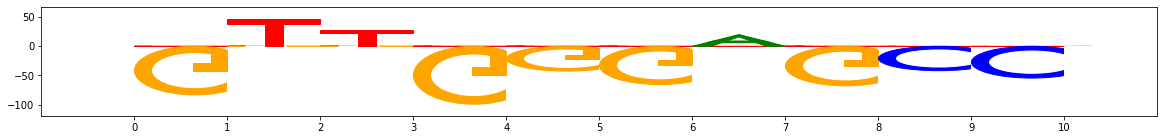

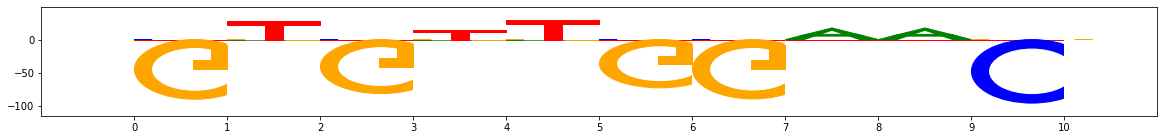

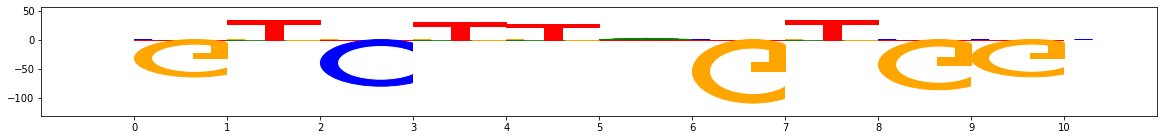

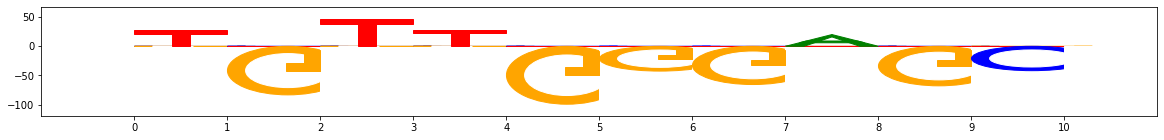

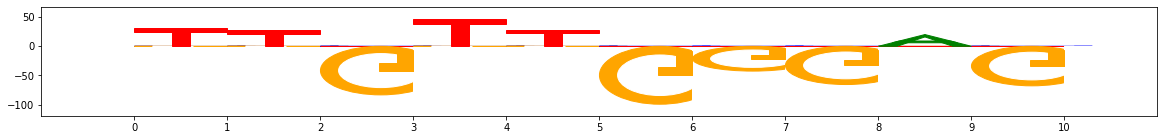

578 397


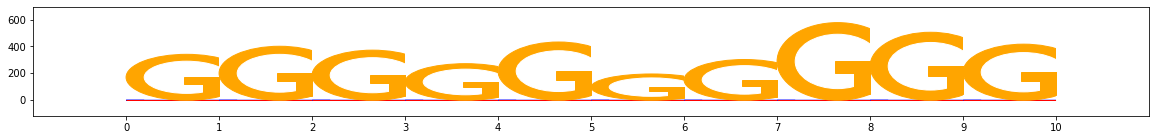

578 399


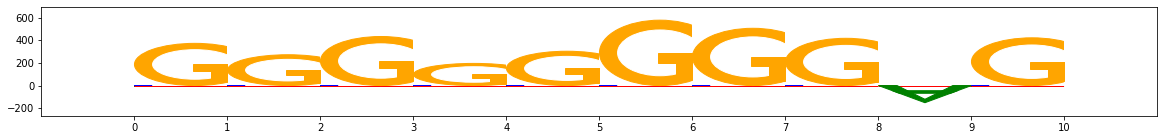

578 398


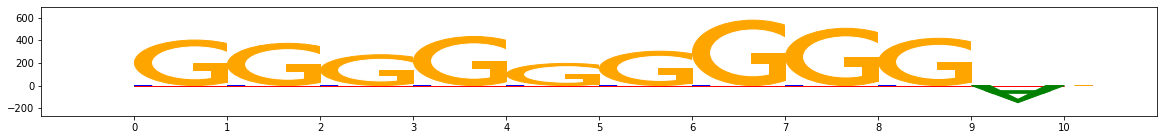

578 396


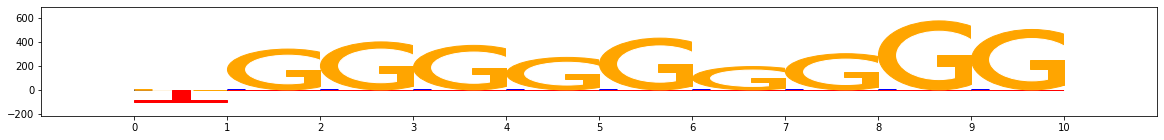

578 401


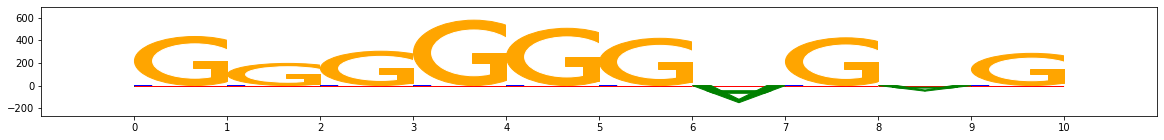

In [30]:
for k in range(5):
    i, j = noprior_windows[k]
    viz_sequence.plot_weights(noprior_scores[i, j:j+10] * one_hot_seqs[i, j:j+10])
print("==============")
for k in range(5):
    i, j = prior_windows[k]
    print(i, j)
    viz_sequence.plot_weights(prior_scores[i, j:j+10] * one_hot_seqs[i, j:j+10])

In [31]:
def compute_distance_mask(scores, one_hot_seqs, summit_offsets, dist_limit, window_size=1):
    """
    Windowing by `window_size`, computes the total importance magnitude for the
    actual importance in each window, and identifies which windows are considered
    close enough to the closest summit.
    Returns a boolean NumPy array denoting which windows are within `dist_limit` of
    the closest summit, sorted in descending order of window importance. 
    """
    num_samples = len(scores)
    all_window_imps, all_dist_masks = [], []
    for i in tqdm.notebook.trange(num_samples):
        score_track = np.sum(np.abs(scores[i] * one_hot_seqs[i]), axis=1)  # Actual importance
        offsets = summit_offsets[i]
        if not offsets:
            print("Warning: found a sequence with no captured summit")
            continue
        num_windows = len(score_track) - window_size + 1
        
        # Compute distances to summits
        distances = np.empty((len(offsets), num_windows))
        window_locs = np.arange(num_windows) + ((len(score_track) - num_windows) / 2)
        for j, offset in enumerate(offsets):
            distances[j] = np.abs(window_locs - offset)
        closest_distances = np.amin(distances, axis=0)
        
        # Compute sum of importance in each window
        importances = np.empty(num_windows)
        for j in range(num_windows):
            importances[j] = np.sum(score_track[j : j + window_size])
        
        all_window_imps.append(importances)
        all_dist_masks.append(closest_distances < dist_limit)
    
    window_imps, dist_mask = np.concatenate(all_window_imps), np.concatenate(all_dist_masks)
    return dist_mask[np.flip(np.argsort(window_imps))]

In [32]:
noprior_dist_mask = compute_distance_mask(noprior_scores, one_hot_seqs, summit_offsets, 100, window_size=10)
prior_dist_mask = compute_distance_mask(prior_scores, one_hot_seqs, summit_offsets, 100, window_size=10)

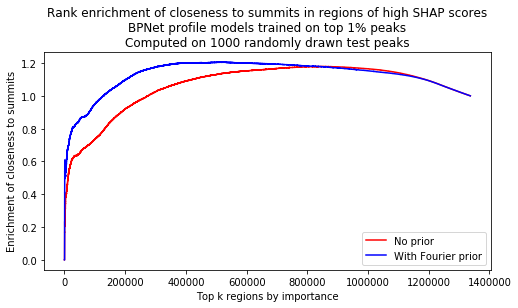

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(normed_rank_enrichment(noprior_dist_mask), label="No prior", color="red")
plt.plot(normed_rank_enrichment(prior_dist_mask), label="With Fourier prior", color="blue")
plt.title(
    ("Rank enrichment of closeness to summits in regions of high %s" % imp_type) +
    ("\n%s %s models trained on %s peaks" % (condition_name, model_type, peak_retention)) +
    ("\nComputed on %d randomly drawn test peaks" % len(sample))
)
plt.xlabel("Top k regions by importance")
plt.ylabel("Enrichment of closeness to summits")
plt.legend()